In [4]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import keras_tuner as kt
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling, GlobalAveragePooling2D, RandomFlip, Input, RandomRotation, RandomContrast
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import random
import seaborn as sn
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/Sentinel2LULC_Test.zip" -d "/content"

In [7]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [8]:
## Leemos las imágenes de train, validacion y test

training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [9]:
## Clase para rotar imagenes solamente en multiplos de 90 (https://errorsfixing.com/rotate-image-for-data-augmentation-using-tf-keras-only-in-specific-angles/)
class Rotate90Randomly(tf.keras.layers.experimental.preprocessing.PreprocessingLayer):
    def __init__(self):
        super(Rotate90Randomly, self).__init__()

    def call(self, x, training=False):
        def random_rotate():
            rotation_factor = tf.random.uniform([], minval=0,
                                                maxval=4, dtype=tf.int32)
            return tf.image.rot90(x, k=rotation_factor)

        training = tf.constant(training, dtype=tf.bool)
        
        rotated = tf.cond(training, random_rotate, lambda: x)
        rotated.set_shape(rotated.shape)
        return rotated

In [ ]:
## Estimación de los hiperparámetros del compilador

def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  augmentation = Sequential([
        RandomFlip(),
        Rotate90Randomly()
  ])
  base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                    weights='imagenet',
                                                    pooling='avg')
  base_model.trainable = False
  entrada = Input(shape=(224,224,3))
  prediction_layer = Dense(29, activation="softmax")
  model = Sequential([
    entrada,
    augmentation,
    base_model,
    BatchNormalization(),
    Dropout(0.2),
    prediction_layer
  ])

  # Tuneamos el learning rate y el optimizador
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
  hp_amsgrad = hp.Choice('amsgrad', values=[True,False])
  model.compile(optimizer=Adam(learning_rate=hp_learning_rate,amsgrad=hp_amsgrad),
                loss=SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  return model

# Instanciamos el tuner
tuner = kt.Hyperband(model_builder, 
                     objective='val_accuracy', 
                     max_epochs=25,
                     factor=3, 
                     directory="/content/drive/MyDrive/ColabNotebooks/Mineria_Aspectos_Avanzados/Competicion_Kaggle/",
                     project_name='khyperbandEfficientNetB2Rotation')

print(tuner.search_space_summary())

# Ejecutamos el tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training,validation_data=validation,epochs=25, callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

print(best_hp.get('learning_rate'))
print(best_hp.get('amsgrad'))

Trial 6 Complete [00h 04m 05s]
val_accuracy: 0.687286913394928

Best val_accuracy So Far: 0.6960545778274536
Total elapsed time: 00h 24m 57s
INFO:tensorflow:Oracle triggered exit
0.001
0


Epoch 1/100
257/257 [==============================] - 96s 329ms/step - loss: 1.7264 - accuracy: 0.4996 - val_loss: 1.3588 - val_accuracy: 0.6415
Epoch 2/100
257/257 [==============================] - 82s 318ms/step - loss: 1.1961 - accuracy: 0.6284 - val_loss: 0.9788 - val_accuracy: 0.6858
Epoch 3/100
257/257 [==============================] - 82s 319ms/step - loss: 1.0560 - accuracy: 0.6576 - val_loss: 0.9100 - val_accuracy: 0.6951
Epoch 4/100
257/257 [==============================] - 82s 318ms/step - loss: 1.0085 - accuracy: 0.6711 - val_loss: 0.9108 - val_accuracy: 0.7004
Epoch 5/100
257/257 [==============================] - 82s 319ms/step - loss: 0.9374 - accuracy: 0.6926 - val_loss: 0.8600 - val_accuracy: 0.7267
Epoch 6/100
257/257 [==============================] - 82s 319ms/step - loss: 0.8983 - accuracy: 0.7045 - val_loss: 0.8321 - val_accuracy: 0.7258
Epoch 7/100
257/257 [==============================] - 82s 318ms/step - loss: 0.8990 - accuracy: 0.7023 - val_loss: 0.8476 -

2022/03/19 17:51:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


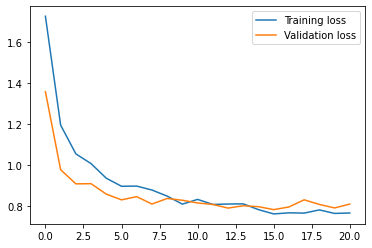

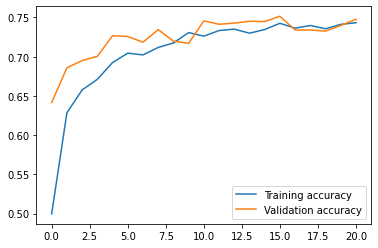

In [12]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Creamos el modelo con las capas de Data Augmentation.
## Solo RandomFlip parece ir bien. 
augmentation = Sequential([
        RandomFlip(),
        Rotate90Randomly(),
        RandomContrast(0.2)
])


## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(include_top=False,
                                                  weights='imagenet',
                                                  pooling='avg')

base_model.trainable = False

## Capa de entrada
entrada = Input(shape=(224,224,3))

## Capa de normalizacion
normalization = Rescaling(1./255)

## Capa de salida
prediction_layer = Dense(29, activation="softmax")

## Creamos nuestro modelo final juntando todos los submodelos/capas
## anteriores
model = Sequential([
  entrada,
  augmentation,
  base_model,
  BatchNormalization(),
  Dropout(0.2),
  prediction_layer
])

opt = Adam(learning_rate=0.001)
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("EfficientNetB2 con DataAugmentation (ImageNet)")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/100
257/257 [==============================] - 328s 1s/step - loss: 1.4573 - accuracy: 0.5882 - val_loss: 2.0113 - val_accuracy: 0.4311
Epoch 2/100
257/257 [==============================] - 305s 1s/step - loss: 0.7858 - accuracy: 0.7550 - val_loss: 0.7170 - val_accuracy: 0.7696
Epoch 3/100
257/257 [==============================] - 306s 1s/step - loss: 0.5864 - accuracy: 0.8043 - val_loss: 0.4684 - val_accuracy: 0.8349
Epoch 4/100
257/257 [==============================] - 306s 1s/step - loss: 0.4842 - accuracy: 0.8329 - val_loss: 0.4603 - val_accuracy: 0.8432
Epoch 5/100
257/257 [==============================] - 306s 1s/step - loss: 0.4273 - accuracy: 0.8506 - val_loss: 0.4297 - val_accuracy: 0.8514
Epoch 6/100
257/257 [==============================] - 306s 1s/step - loss: 0.3842 - accuracy: 0.8678 - val_loss: 0.3840 - val_accuracy: 0.8660
Epoch 7/100
257/257 [==============================] - 306s 1s/step - loss: 0.3296 - accuracy: 0.8840 - val_loss: 0.4105 - val_accuracy:

2022/03/19 18:50:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


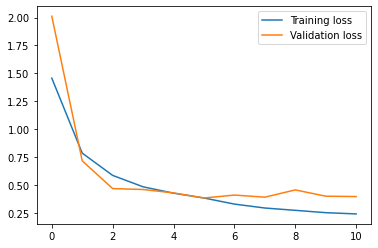

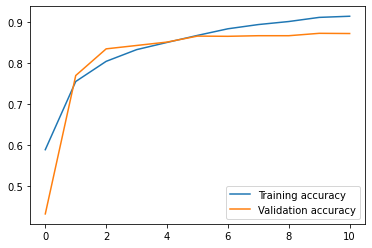

In [13]:
## FINE TUNING: Volvemos a entrenar descongelando algunas capas (menos las BatchNormalization)

def unfreeze_model(model):
    for layer in model.layers[-23:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    opt = Adam(learning_rate=1e-4)
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])


unfreeze_model(model)

with mlflow.start_run():
  callback = EarlyStopping(patience=5,restore_best_weights=True)
  history = model.fit(training,
                    epochs=100,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [14]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10  9 10 ...  9  9 20]


In [15]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('EfficientNetB2_ImageNet_Random90Rotation_RandomContrast.csv', index=False)
files.download('EfficientNetB2_ImageNet_Random90Rotation_RandomContrast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

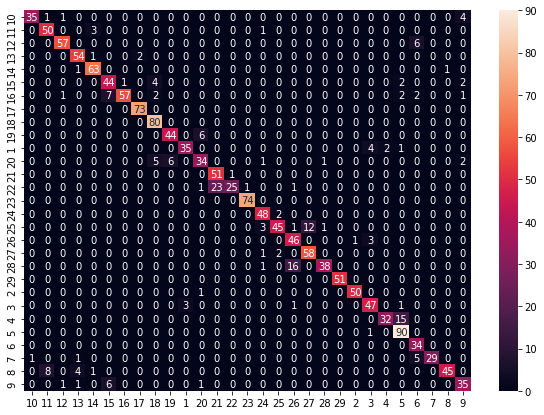

In [16]:
## Sacamos la matriz de confusion

clases = []
dirname = sorted(os.listdir("Sentinel2LULC_Test"))
for names in dirname:
  clases.append(names.split('_')[0])

clases = [int(x) for x in clases]

indexes = [i for i in range(10,20)]+[1]+[i for i in range(20,30)]+[i for i in range(2,10)]

matrix = confusion_matrix(clases, list(classes),labels=indexes)

df_cm = pd.DataFrame(matrix, index = indexes, columns = indexes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)